In [2]:
import sys
sys.path.append("..")
from src import model
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import numpy as np
from matplotlib import cm

events = pd.read_csv("../data/G12_PAADPANET_PM_z10_Events.csv", index_col=0)
log_theta = pd.read_csv("../data/prad_0.01", index_col=0)
tau1, tau2 = log_theta[:2, -1]
log_theta =log_theta[:, :-1]
metMHN = model.MetMHN(log_theta=log_theta, tau1=tau1, tau2=tau2)

AttributeError: type object 'MetMHN' has no attribute 'load'

In [24]:
events[events["paired"] == False]
met = events[events["P.AgeAtSeqRep"] == "No primary included"].loc[:, ~events.columns.isin(['paired', 'P.AgeAtSeqRep','M.AgeAtSeqRep'])].astype(int)
met = met[met.columns[[c.startswith("M") for c in met.columns]]]
met["Seeding"] = 1

In [25]:
orders = [tuple(mhn.likeliest_order(row)[1]) for _, row in met.iterrows()]
g = mhn.history_tree(orders)

In [26]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

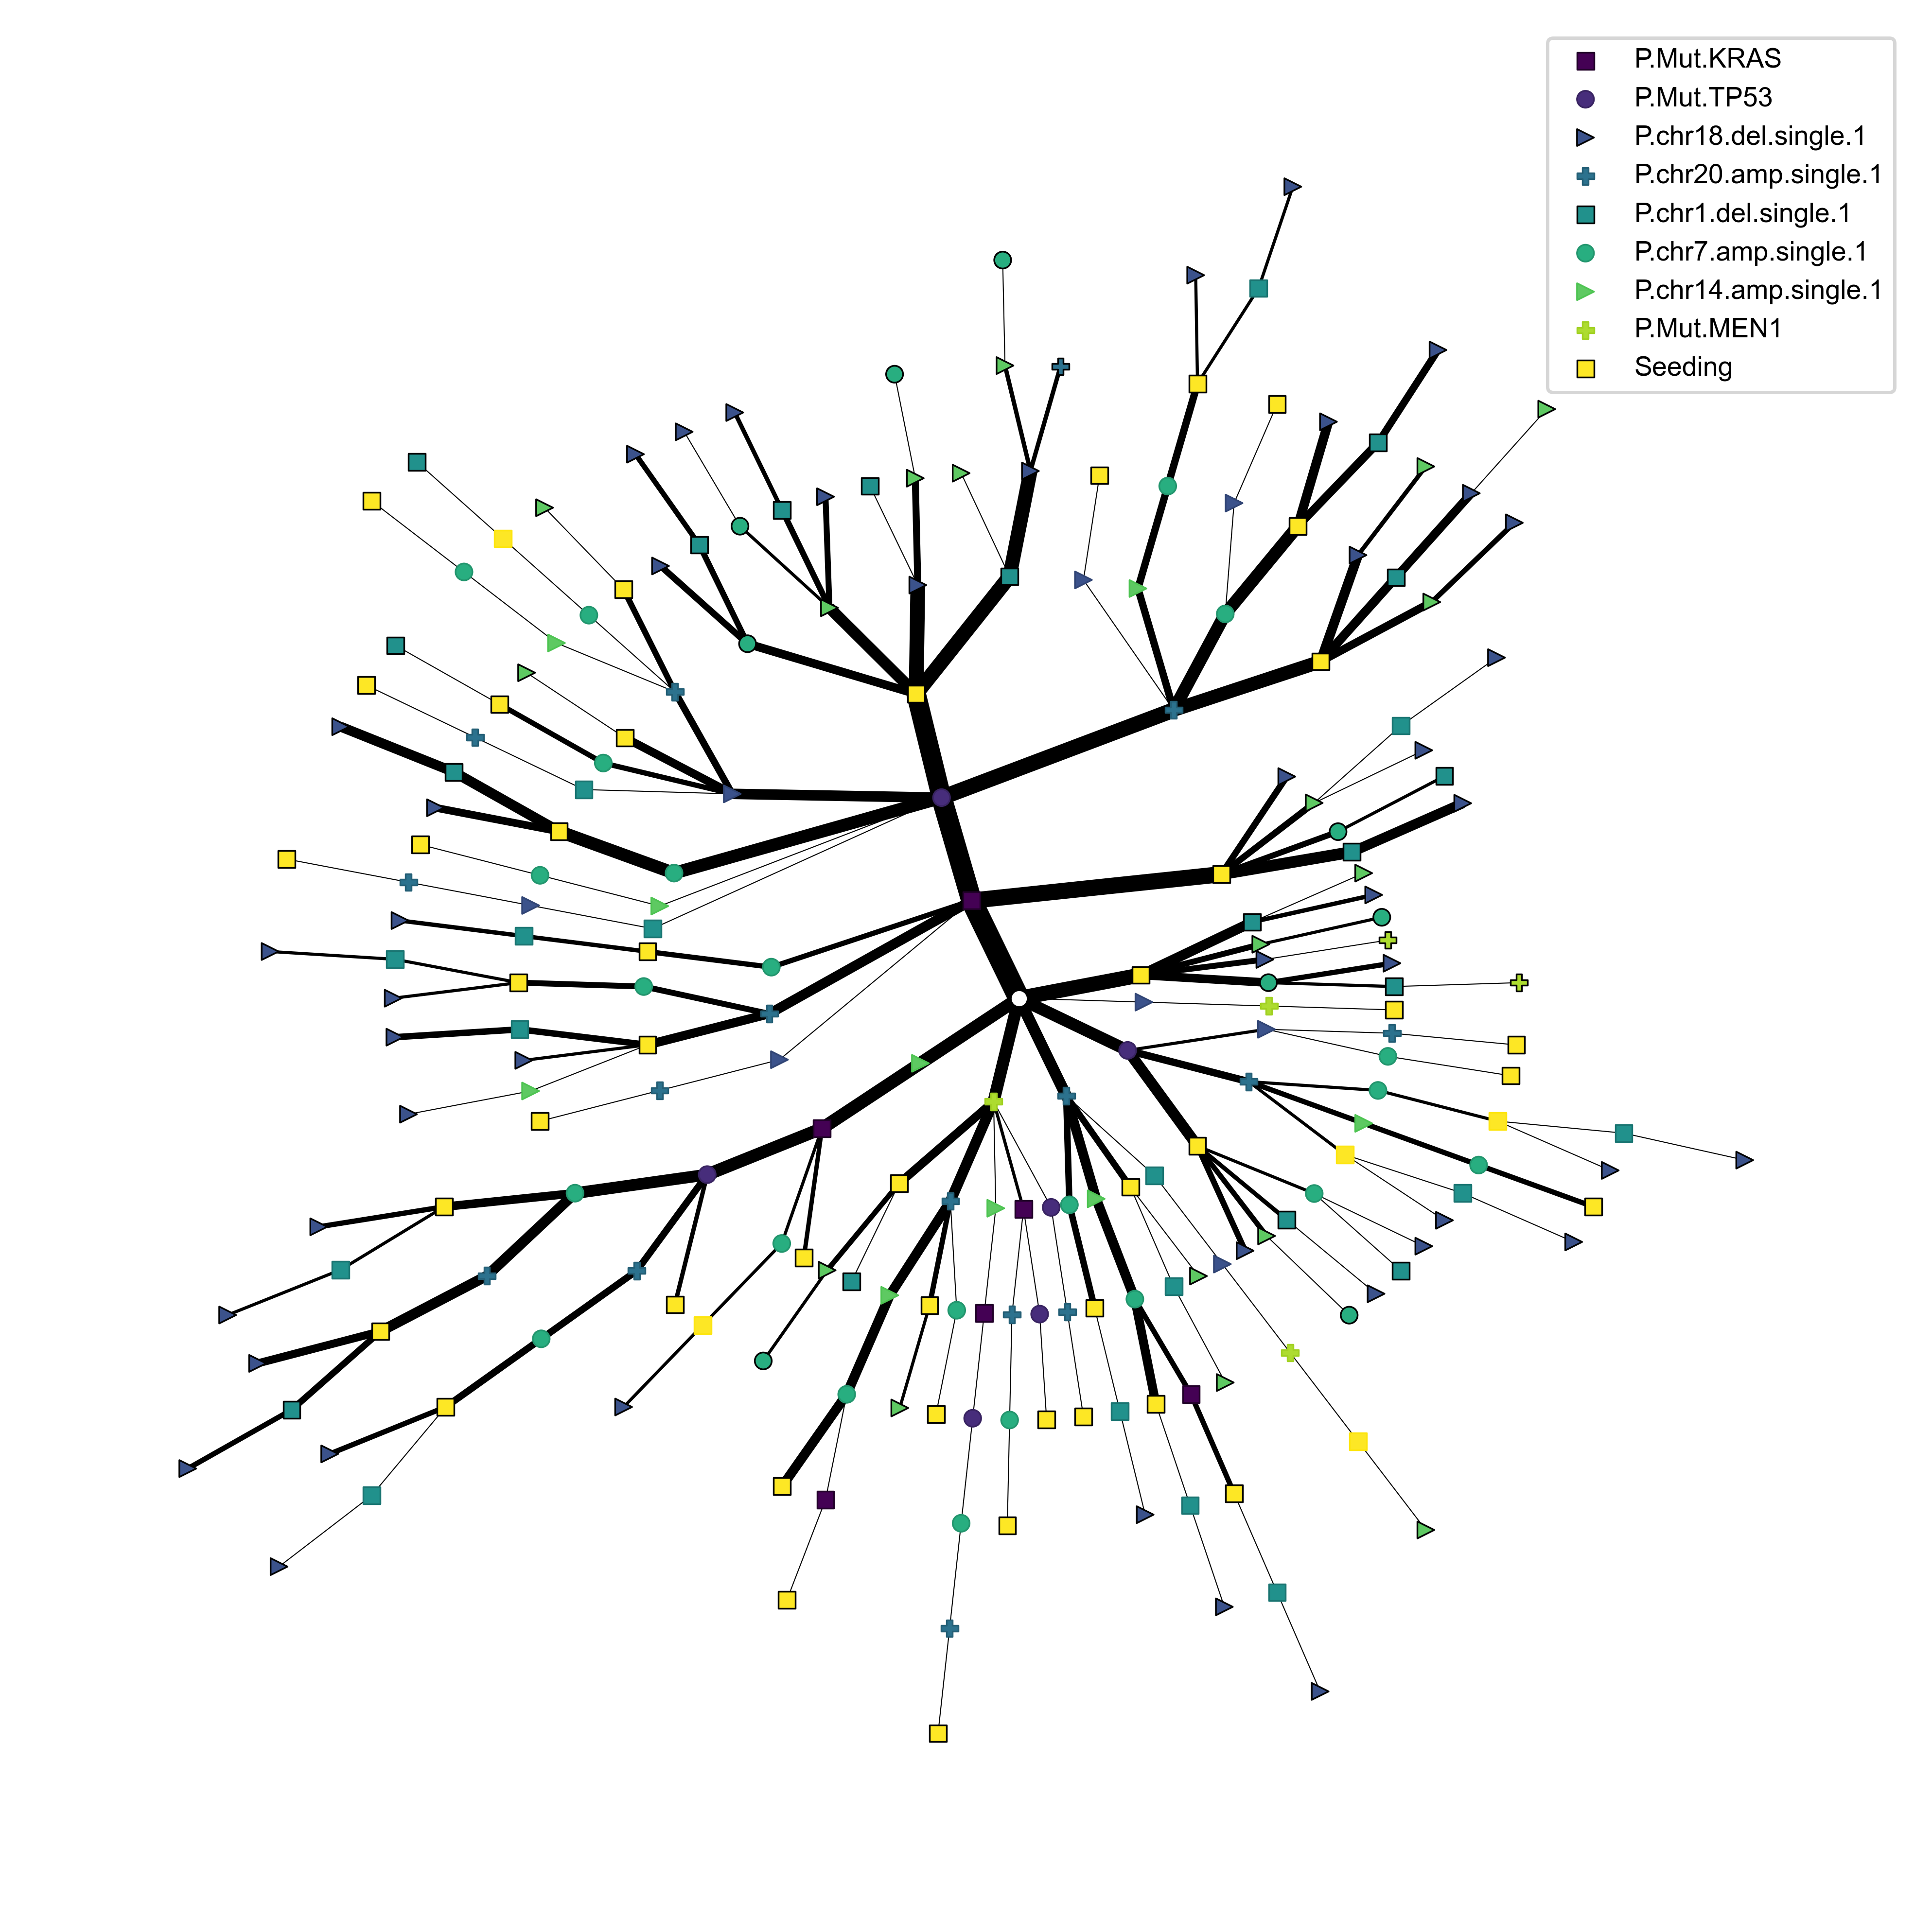

In [27]:
f, axis = plt.subplots()
legend_alias = {i: e for i, e in enumerate(mhn.events)}
markers = ["s", "o", ">", "P"]
cmap = cm.viridis
node_size = 25
contour_width = 0.5
always_contour = False
root = ()
legend_kws = {"size": 8, "family": "Arial"}
colors = None


importance = np.abs(mhn.log_theta - np.diag(np.diag(mhn.log_theta)))
importance = importance.sum(axis=0) + importance.sum(axis=1)
filtered_events = np.arange(mhn.log_theta.shape[0])[
    np.argsort(importance)[:-10:-1]]

orders = [tuple(event for event in o if event in filtered_events)
          for o in orders]

g = mhn.history_tree(orders)

if isinstance(markers, list):
    markers = {n: m for n, m in zip(
        g.graph["observations"], itertools.cycle(markers))}

if colors is None:
    colors = {n: cmap(i)
              for n, i in zip(
                  g.graph["observations"], np.linspace(0, 1, len(g.graph["observations"])))}


labels_to_int = {}
int_to_labels = {}
for i, label in enumerate(g):
    labels_to_int[label] = i
    int_to_labels[i] = label

nx.relabel_nodes(g, labels_to_int, copy=False)
pos = nx.nx_agraph.graphviz_layout(
    g, prog="twopi", args="", root=labels_to_int[root])
nx.nx_agraph.graphviz_layout(g, prog="twopi")

nx.relabel_nodes(g, int_to_labels, copy=False)

pos = {label: pos[labels_to_int[label]] for label in g}

node_dict = {obs: [n for n in g if (
    n != () and n[-1] == obs)] for obs in g.graph["observations"]}


nx.draw_networkx_edges(g, pos,
                       width=[0.9 *np.log(g.edges[(e1, e2)]["weight"]) + 0.3 for e1, e2 in g.edges],
                        # width=0.5,
                       ax=axis,
                       )

for obs in g.graph["observations"]:
    nx.draw_networkx_nodes(g, pos, nodelist=node_dict[obs],
                           node_size=node_size,
                           label=legend_alias.get(
        obs, str(obs)[:min(20, len(str(obs)))]),
        node_shape=markers[obs],
        node_color=[colors[obs]],
        edgecolors=["black" if g.nodes[n].get("terminal") else
                    # "silver"
                    lighten_color(colors[obs], 1.1)
                    for n in node_dict[obs]]
        if not always_contour else "black",
        linewidths=contour_width,
        ax=axis)
if root == ():
    nx.draw_networkx_nodes(
        g,
        pos,
        nodelist=[()],
        node_size=node_size,
        node_color="white", edgecolors="black", linewidths=contour_width, ax=axis)
axis.axis("off")

axis.legend(prop=legend_kws)

axis.axis("off")
f.set_dpi(500)
f.set_size_inches(10, 10)